# **1- Upgrades**

In [1]:
!pip install --upgrade kornia > /dev/null
!pip install --upgrade fastai > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-transform 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.3 which is incompatible.
tensorflow-transform 1.5.0 requires pyarrow<6,>=1, but you have p

# **2- Imports**

In [2]:
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

# **3- Data Preparation**

In [3]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    

,dirname,filename
89,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
81,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
142,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
31,../input/liver-tumor-segmentation/segmentations,segmentation-100.nii
45,../input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...
243,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-95.nii
222,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-96.nii
217,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-97.nii
252,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-98.nii


In [4]:
# Map CT scan and label 

df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "../input/liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files

,dirname,filename,mask_dirname,mask_filename
0,../input/liver-tumor-segmentation/volume_pt1,volume-0.nii,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,../input/liver-tumor-segmentation/volume_pt1,volume-1.nii,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,../input/liver-tumor-segmentation/volume_pt1,volume-10.nii,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-100.nii,../input/liver-tumor-segmentation/segmentations,segmentation-100.nii
4,../input/liver-tumor-segmentation-part-2/volume_pt8,volume-101.nii,../input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...,...,...
126,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-95.nii,../input/liver-tumor-segmentation/segmentations,segmentation-95.nii
127,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-96.nii,../input/liver-tumor-segmentation/segmentations,segmentation-96.nii
128,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-97.nii,../input/liver-tumor-segmentation/segmentations,segmentation-97.nii
129,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-98.nii,../input/liver-tumor-segmentation/segmentations,segmentation-98.nii


In [5]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [6]:
# Read sample

sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


In [7]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


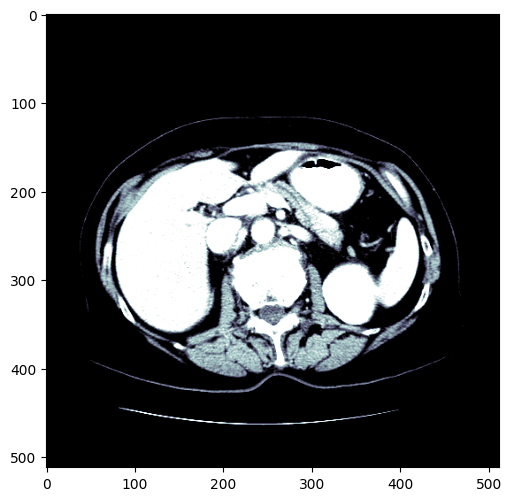

In [8]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)

plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [9]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    plt.axis('off')
             
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('off')
    
    plt.show()

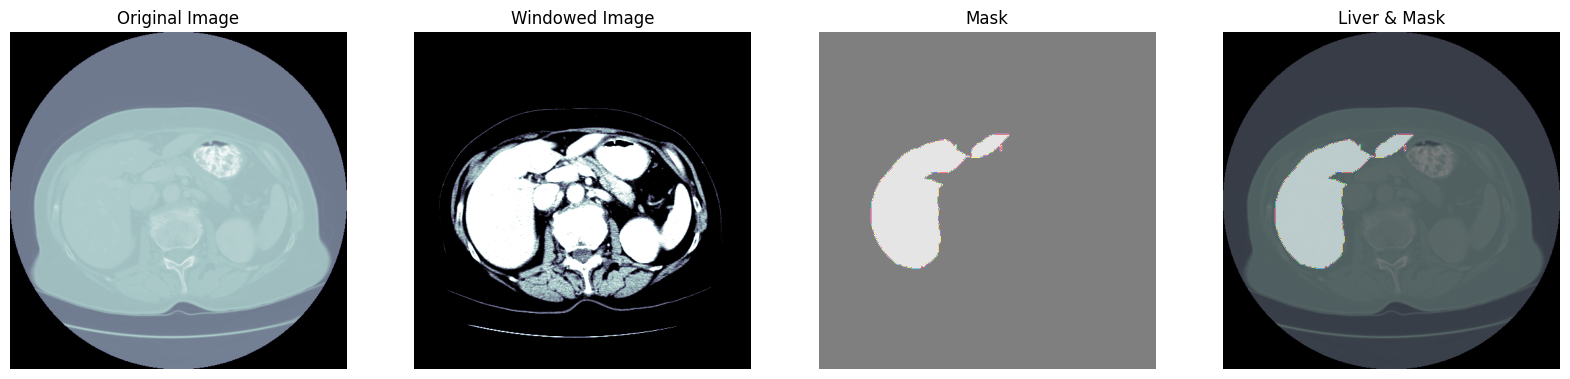

In [10]:
sample = 55

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])

In [11]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print(np.array((unique, counts)).T)

[[     0 244111]
 [     1  18033]]


<AxesSubplot:>

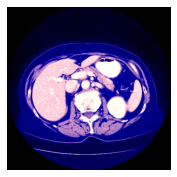

In [12]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=120):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs = subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0], figsize=(8, 6))

In [13]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 67072 slices 

GENERATE_JPG_FILES = True

if (GENERATE_JPG_FILES) :
    
    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files),3)): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    path = Path("../input/liver-segmentation-with-fastai-v2") # read jpg from saved kernel output

  0%|          | 0/44 [00:00<?, ?it/s]

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


# **3- Model Training**
### Using ResNet-50 model from [ResNet](https://arxiv.org/pdf/1512.03385.pdf)

In [14]:
BATCH_SIZE = 16
IMAGE_SIZE = 128

codes = np.array(["background","liver","tumor"])
    
def get_x(fname:Path): return fname
def label_func(x): return path/'train_masks'/f'{x.stem}_mask.png'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  #codes = {"Backround": 0,"Liver": 1,"Tumor": 2}
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(IMAGE_SIZE)],
               get_items=get_image_files,
               get_y=label_func)

ds = db.datasets(source=path/'train_images')

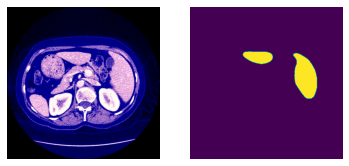

In [15]:
idx = 20
imgs = [ds[idx][0],ds[idx][1]]
fig, axs = plt.subplots(1, 2)

for i,ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.imshow(imgs[i])

In [16]:
unique, counts = np.unique(array(ds[idx][1]), return_counts=True)

print( np.array((unique, counts)).T)

[[     0 250526]
 [     1  11618]]


/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:461.)
  return torch.floor_divide(self, other)


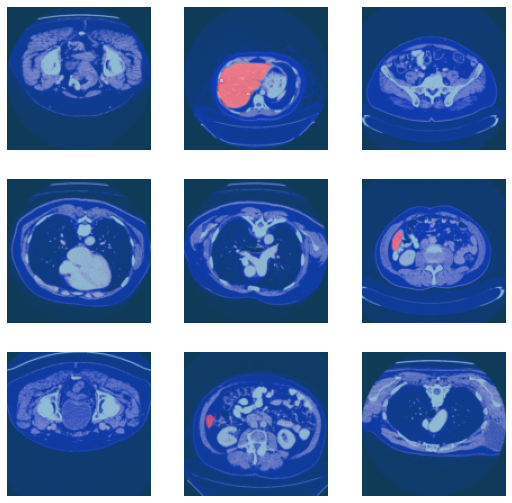

In [17]:
dls = db.dataloaders(path/'train_images', bs = BATCH_SIZE) #, num_workers=0
dls.show_batch()

In [18]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):  # exclude a background from metric
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean() 

def cust_foreground_acc(inp, targ):  # # include a background into the metric
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1) # 3 is a dummy value to include the background which is 0

In [19]:
learn = unet_learner(dls,
                     resnet50,
                     loss_func=CrossEntropyLossFlat(axis=1),
                     metrics=[foreground_acc, cust_foreground_acc]) 

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [20]:
learn.fine_tune(5, wd=0.1, cbs=SaveModelCallback() )

epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.013555,0.009279,nan,0.996783,05:55


Better model found at epoch 0 with valid_loss value: 0.009279245510697365.


epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.006946,0.008413,nan,0.997054,05:52
1,0.006379,0.007789,nan,0.997459,05:51
2,0.003675,0.003594,nan,0.998611,05:52
3,0.002829,0.003090,nan,0.998775,05:51
4,0.002626,0.002973,nan,0.998820,05:51


Better model found at epoch 0 with valid_loss value: 0.008413443341851234.
Better model found at epoch 1 with valid_loss value: 0.0077891903929412365.
Better model found at epoch 2 with valid_loss value: 0.003593928413465619.
Better model found at epoch 3 with valid_loss value: 0.003089932259172201.
Better model found at epoch 4 with valid_loss value: 0.0029729194939136505.


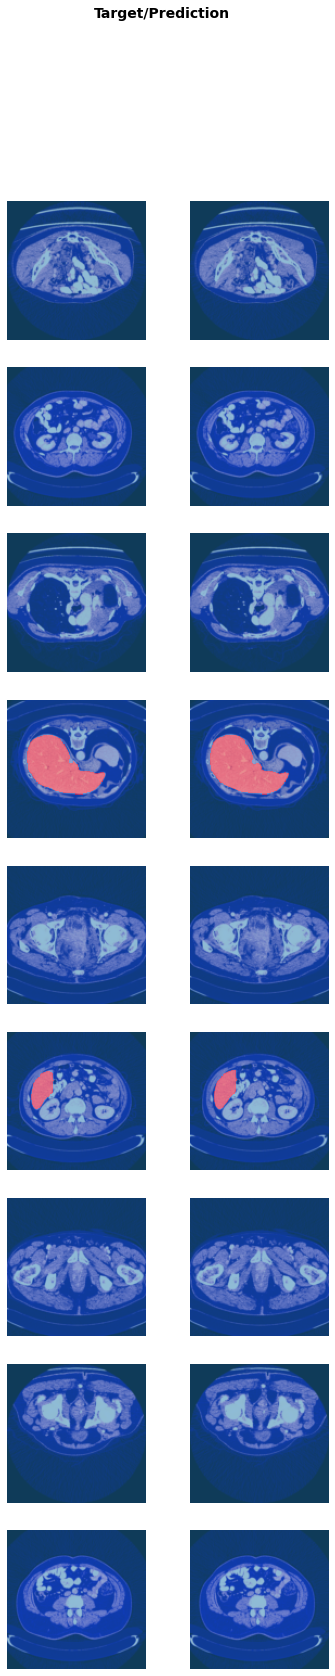

In [21]:
learn.show_results()

In [22]:
# Save the model
learn.export(path/f'Liver_segmentation')

# **4- Testing the Model**

In [23]:
# Load saved model
if (GENERATE_JPG_FILES) :
    
    tfms = [Resize(IMAGE_SIZE), IntToFloatTensor(),Normalize()]
    learn0 = load_learner(path/f'Liver_segmentation',cpu=False )
    learn0.dls.transform = tfms

In [24]:
def nii_tfm(fn,wins): 

    test_nii  = read_nii(fn)
    curr_dim  = test_nii.shape[2] # 512, 512, curr_dim
    slices = []
    
    for curr_slice in range(curr_dim):
        data = tensor(test_nii[...,curr_slice].astype(np.float32))
        data = (data.to_nchan(wins)*255).byte()
        slices.append(TensorImage(data))
                      
    return slices 

(512, 512, 908)


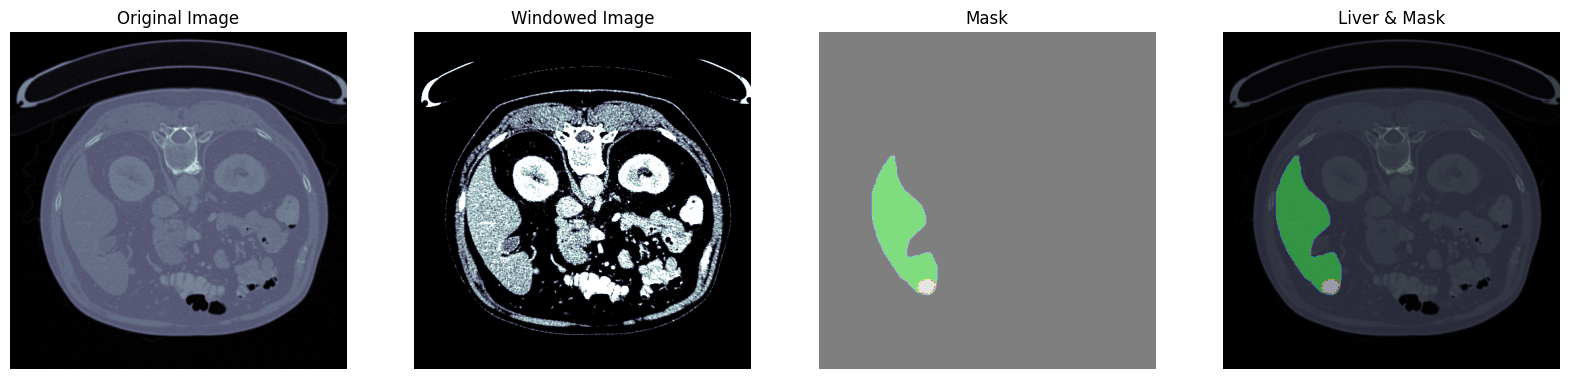

In [25]:
tst = 20

test_nii   = read_nii(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'])
test_mask  = read_nii(df_files.loc[tst,'mask_dirname']+"/"+df_files.loc[tst,'mask_filename'])
print(test_nii.shape)

test_slice_idx = 500

sample_slice = tensor(test_nii[...,test_slice_idx].astype(np.float32))

plot_sample([test_nii[...,test_slice_idx], test_mask[...,test_slice_idx]])

In [26]:
# Prepare a nii test file for prediction 

test_files = nii_tfm(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'],[dicom_windows.liver, dicom_windows.custom])
print("Number of test slices: ", len(test_files))

Number of test slices:  908


<AxesSubplot:>

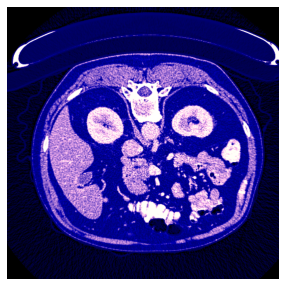

In [27]:
# Check an input for a test file
show_image(test_files[test_slice_idx])

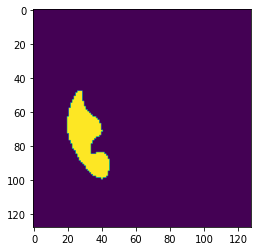

In [28]:
# Get predictions for a Test file

test_dl = learn0.dls.test_dl(test_files)
preds, y = learn0.get_preds(dl=test_dl)

predicted_mask = np.argmax(preds, axis=1)

plt.imshow(predicted_mask[test_slice_idx])

-----
# **5- Conclusion**
### If you compare the predicted mask with the previous image, you'll see that the model performed quite good.